<a href="https://colab.research.google.com/github/kridtapon/TrixDeMark-Momentum/blob/main/TrixDeMark_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

[*********************100%***********************]  1 of 1 completed


Best parameters found:
Trix Period: 10.0
Demarker Period: 2.0
Total Return: 1.6909234994255606


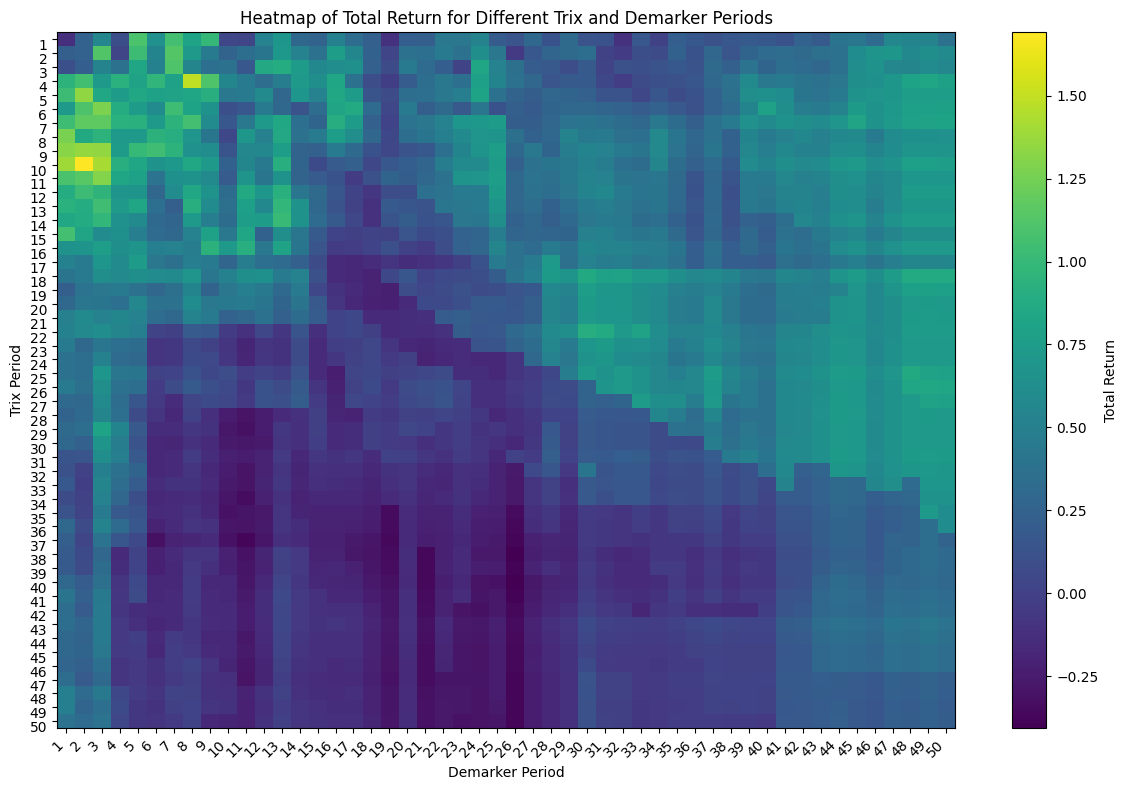

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           269092.349943
Total Return [%]                        169.09235
Benchmark Return [%]                   114.263729
Max Gross Exposure [%]                      100.0
Total Fees Paid                       10401.13638
Max Drawdown [%]                        17.963748
Max Drawdown Duration                       214.0
Total Trades                                   35
Total Closed Trades                            35
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            48.571429
Best Trade [%]                          21.505483
Worst Trade [%]                         -7.910329
Avg Winning Trade [%]                    9.230246
Avg Losing Trade [%]                    -2.614381


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product
import matplotlib.pyplot as plt

# Function to calculate Trix Indicator and Signal Line
def calculate_trix(df, period=14):
    period = int(period)
    ema1 = df['Close'].ewm(span=period).mean()
    ema2 = ema1.ewm(span=period).mean()
    ema3 = ema2.ewm(span=period).mean()
    trix = ema3.pct_change() * 100
    trix_signal = trix.ewm(span=9).mean()
    return trix, trix_signal

# Function to calculate Demarker Indicator
def calculate_demarker(df, period=14):
    period = int(period)
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    dm_plus = high_diff.where(high_diff > low_diff, 0)
    dm_minus = low_diff.where(low_diff > high_diff, 0)
    smoothed_dm_plus = dm_plus.rolling(window=period).sum()
    smoothed_dm_minus = dm_minus.rolling(window=period).sum()
    demarker = smoothed_dm_plus / (smoothed_dm_plus + smoothed_dm_minus)
    return demarker

# Define the stock symbol and time period
symbol = 'IBM'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define a range of periods for Trix and Demarker
trix_periods = range(1, 51)  # Example range of 1 to 50 for Trix
demarker_periods = range(1, 51)  # Example range of 1 to 50 for Demarker

# Create a parameter grid
param_grid = list(product(trix_periods, demarker_periods))

# Function to calculate portfolio stats for given periods
def calculate_performance(trix_period, demarker_period):
    df['Trix'], df['Trix_Signal'] = calculate_trix(df, period=trix_period)
    df['Demarker'] = calculate_demarker(df, period=demarker_period)

    df['Entry'] = (df['Trix'] > df['Trix_Signal']) & (df['Demarker'] < 0.3)
    df['Exit'] = (df['Trix'] < df['Trix_Signal']) & (df['Demarker'] > 0.7)

    df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    portfolio = vbt.Portfolio.from_signals(
        close=df_filtered['Close'],
        entries=df_filtered['Entry'],
        exits=df_filtered['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    return portfolio.total_return()  # You can also optimize for other metrics like Sharpe ratio

# Perform grid search
results = []
for trix_period, demarker_period in param_grid:
    total_return = calculate_performance(trix_period, demarker_period)
    results.append((trix_period, demarker_period, total_return))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Trix Period', 'Demarker Period', 'Total Return'])

# Find the best parameters
best_result = results_df.loc[results_df['Total Return'].idxmax()]
print("Best parameters found:")
print(f"Trix Period: {best_result['Trix Period']}")
print(f"Demarker Period: {best_result['Demarker Period']}")
print(f"Total Return: {best_result['Total Return']}")

# Create a pivot table to use for the heatmap
heatmap_data = results_df.pivot(index='Trix Period', columns='Demarker Period', values='Total Return')

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Increase the figure size
plt.imshow(heatmap_data, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Total Return')
plt.xlabel('Demarker Period')
plt.ylabel('Trix Period')
plt.title('Heatmap of Total Return for Different Trix and Demarker Periods')

# Adjust the tick spacing and rotation to avoid overlap
plt.xticks(ticks=np.arange(len(demarker_periods)), labels=demarker_periods, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(trix_periods)), labels=trix_periods, va='top')

plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.show()

# Plot performance for the best parameters
best_trix_period = best_result['Trix Period']
best_demarker_period = best_result['Demarker Period']

df['Trix'], df['Trix_Signal'] = calculate_trix(df, period=best_trix_period)
df['Demarker'] = calculate_demarker(df, period=best_demarker_period)

df['Entry'] = (df['Trix'] > df['Trix_Signal']) & (df['Demarker'] < 0.3)
df['Exit'] = (df['Trix'] < df['Trix_Signal']) & (df['Demarker'] > 0.7)

df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

portfolio = vbt.Portfolio.from_signals(
    close=df_filtered['Close'],
    entries=df_filtered['Entry'],
    exits=df_filtered['Exit'],
    init_cash=100_000,
    fees=0.001
)

portfolio.plot().show()

print(portfolio.stats())


[*********************100%***********************]  1 of 1 completed


Best parameters found:
Trix Period: 22.0
Demarker Period: 30.0
Total Return: 3.0047221115255445


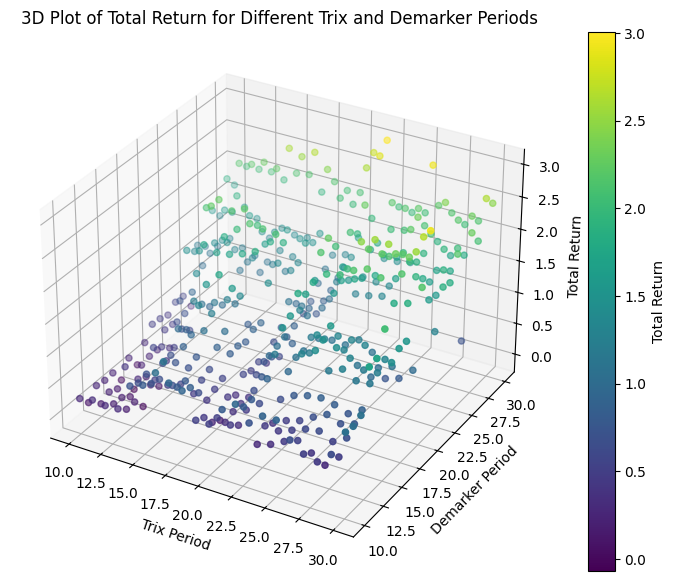

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           400472.211153
Total Return [%]                       300.472211
Benchmark Return [%]                   180.172878
Max Gross Exposure [%]                      100.0
Total Fees Paid                       3211.396689
Max Drawdown [%]                        44.467225
Max Drawdown Duration                       381.0
Total Trades                                    9
Total Closed Trades                             9
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            66.666667
Best Trade [%]                          75.374404
Worst Trade [%]                        -29.955821
Avg Winning Trade [%]                   38.480028
Avg Losing Trade [%]                   -13.813661


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to calculate Trix Indicator and Signal Line
def calculate_trix(df, period=14):
    period = int(period)
    ema1 = df['Close'].ewm(span=period).mean()
    ema2 = ema1.ewm(span=period).mean()
    ema3 = ema2.ewm(span=period).mean()
    trix = ema3.pct_change() * 100
    trix_signal = trix.ewm(span=9).mean()
    return trix, trix_signal

# Function to calculate Demarker Indicator
def calculate_demarker(df, period=14):
    period = int(period)
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    dm_plus = high_diff.where(high_diff > low_diff, 0)
    dm_minus = low_diff.where(low_diff > high_diff, 0)
    smoothed_dm_plus = dm_plus.rolling(window=period).sum()
    smoothed_dm_minus = dm_minus.rolling(window=period).sum()
    demarker = smoothed_dm_plus / (smoothed_dm_plus + smoothed_dm_minus)
    return demarker

# Define the stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define a range of periods for Trix and Demarker
trix_periods = range(10, 31)  # Example range of 10 to 30 for Trix
demarker_periods = range(10, 31)  # Example range of 10 to 30 for Demarker

# Create a parameter grid
param_grid = list(product(trix_periods, demarker_periods))

# Function to calculate portfolio stats for given periods
def calculate_performance(trix_period, demarker_period):
    df['Trix'], df['Trix_Signal'] = calculate_trix(df, period=trix_period)
    df['Demarker'] = calculate_demarker(df, period=demarker_period)

    df['Entry'] = (df['Trix'] > df['Trix_Signal']) & (df['Demarker'] < 0.3)
    df['Exit'] = (df['Trix'] < df['Trix_Signal']) & (df['Demarker'] > 0.7)

    df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    portfolio = vbt.Portfolio.from_signals(
        close=df_filtered['Close'],
        entries=df_filtered['Entry'],
        exits=df_filtered['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    return portfolio.total_return()  # You can also optimize for other metrics like Sharpe ratio

# Perform grid search
results = []
for trix_period, demarker_period in param_grid:
    total_return = calculate_performance(trix_period, demarker_period)
    results.append((trix_period, demarker_period, total_return))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Trix Period', 'Demarker Period', 'Total Return'])

# Find the best parameters
best_result = results_df.loc[results_df['Total Return'].idxmax()]
print("Best parameters found:")
print(f"Trix Period: {best_result['Trix Period']}")
print(f"Demarker Period: {best_result['Demarker Period']}")
print(f"Total Return: {best_result['Total Return']}")

# Plot 3D performance for all parameters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
scat = ax.scatter(
    results_df['Trix Period'],
    results_df['Demarker Period'],
    results_df['Total Return'],
    c=results_df['Total Return'], cmap='viridis', marker='o'
)

# Add color bar
cbar = fig.colorbar(scat)
cbar.set_label('Total Return')

ax.set_xlabel('Trix Period')
ax.set_ylabel('Demarker Period')
ax.set_zlabel('Total Return')
ax.set_title('3D Plot of Total Return for Different Trix and Demarker Periods')

plt.show()

# Plot performance for the best parameters
best_trix_period = best_result['Trix Period']
best_demarker_period = best_result['Demarker Period']

df['Trix'], df['Trix_Signal'] = calculate_trix(df, period=best_trix_period)
df['Demarker'] = calculate_demarker(df, period=best_demarker_period)

df['Entry'] = (df['Trix'] > df['Trix_Signal']) & (df['Demarker'] < 0.3)
df['Exit'] = (df['Trix'] < df['Trix_Signal']) & (df['Demarker'] > 0.7)

df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

portfolio = vbt.Portfolio.from_signals(
    close=df_filtered['Close'],
    entries=df_filtered['Entry'],
    exits=df_filtered['Exit'],
    init_cash=100_000,
    fees=0.001
)

portfolio.plot().show()

print(portfolio.stats())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Best parameters found:
Trix Period: 22.0
Demarker Period: 30.0
Total Return: 3.0047221115255445


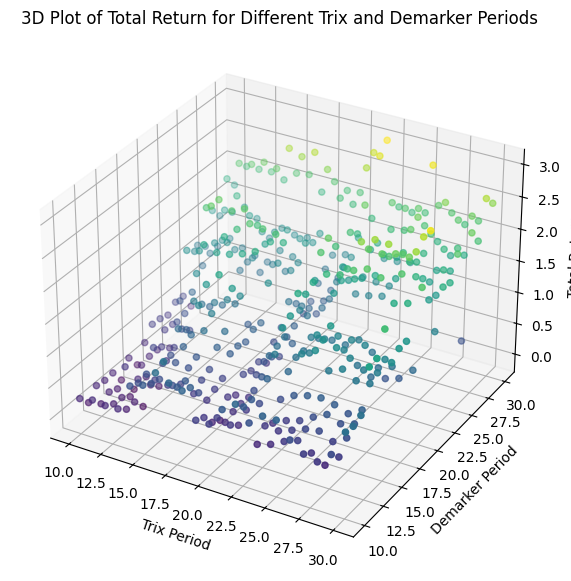

ValueError: window must be an integer 0 or greater

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to calculate Trix Indicator and Signal Line
def calculate_trix(df, period=14):
    period = int(period)
    ema1 = df['Close'].ewm(span=period).mean()
    ema2 = ema1.ewm(span=period).mean()
    ema3 = ema2.ewm(span=period).mean()
    trix = ema3.pct_change() * 100
    trix_signal = trix.ewm(span=9).mean()
    return trix, trix_signal

# Function to calculate Demarker Indicator
def calculate_demarker(df, period=14):
    period = int(period)
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    dm_plus = high_diff.where(high_diff > low_diff, 0)
    dm_minus = low_diff.where(low_diff > high_diff, 0)
    smoothed_dm_plus = dm_plus.rolling(window=period).sum()
    smoothed_dm_minus = dm_minus.rolling(window=period).sum()
    demarker = smoothed_dm_plus / (smoothed_dm_plus + smoothed_dm_minus)
    return demarker

# Define the stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define a range of periods for Trix and Demarker
trix_periods = range(10, 31)  # Example range of 10 to 30 for Trix
demarker_periods = range(10, 31)  # Example range of 10 to 30 for Demarker

# Create a parameter grid
param_grid = list(product(trix_periods, demarker_periods))

# Function to calculate portfolio stats for given periods
def calculate_performance(trix_period, demarker_period):
    df['Trix'], df['Trix_Signal'] = calculate_trix(df, period=trix_period)
    df['Demarker'] = calculate_demarker(df, period=demarker_period)

    df['Entry'] = (df['Trix'] > df['Trix_Signal']) & (df['Demarker'] < 0.3)
    df['Exit'] = (df['Trix'] < df['Trix_Signal']) & (df['Demarker'] > 0.7)

    df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    portfolio = vbt.Portfolio.from_signals(
        close=df_filtered['Close'],
        entries=df_filtered['Entry'],
        exits=df_filtered['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    return portfolio.total_return()  # You can also optimize for other metrics like Sharpe ratio

# Perform grid search
results = []
for trix_period, demarker_period in param_grid:
    total_return = calculate_performance(trix_period, demarker_period)
    results.append((trix_period, demarker_period, total_return))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Trix Period', 'Demarker Period', 'Total Return'])

# Find the best parameters
best_result = results_df.loc[results_df['Total Return'].idxmax()]
print("Best parameters found:")
print(f"Trix Period: {best_result['Trix Period']}")
print(f"Demarker Period: {best_result['Demarker Period']}")
print(f"Total Return: {best_result['Total Return']}")

# Plot 3D performance for all parameters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
ax.scatter(
    results_df['Trix Period'],
    results_df['Demarker Period'],
    results_df['Total Return'],
    c=results_df['Total Return'], cmap='viridis', marker='o'
)

ax.set_xlabel('Trix Period')
ax.set_ylabel('Demarker Period')
ax.set_zlabel('Total Return')
ax.set_title('3D Plot of Total Return for Different Trix and Demarker Periods')

plt.show()

# Plot performance for the best parameters
best_trix_period = best_result['Trix Period']
best_demarker_period = best_result['Demarker Period']

df['Trix'], df['Trix_Signal'] = calculate_trix(df, period=best_trix_period)
df['Demarker'] = calculate_demarker(df, period=best_demarker_period)

df['Entry'] = (df['Trix'] > df['Trix_Signal']) & (df['Demarker'] < 0.3)
df['Exit'] = (df['Trix'] < df['Trix_Signal']) & (df['Demarker'] > 0.7)

df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

portfolio = vbt.Portfolio.from_signals(
    close=df_filtered['Close'],
    entries=df_filtered['Entry'],
    exits=df_filtered['Exit'],
    init_cash=100_000,
    fees=0.001
)

portfolio.plot().show()

print(portfolio.stats())

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Function to calculate Trix Indicator and Signal Line
def calculate_trix(df, period=14):
    ema1 = df['Close'].ewm(span=period).mean()
    ema2 = ema1.ewm(span=period).mean()
    ema3 = ema2.ewm(span=period).mean()
    trix = ema3.pct_change() * 100
    trix_signal = trix.ewm(span=9).mean()
    return trix, trix_signal

# Function to calculate Demarker Indicator
def calculate_demarker(df, period=14):
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    dm_plus = high_diff.where(high_diff > low_diff, 0)
    dm_minus = low_diff.where(low_diff > high_diff, 0)
    smoothed_dm_plus = dm_plus.rolling(window=period).sum()
    smoothed_dm_minus = dm_minus.rolling(window=period).sum()
    demarker = smoothed_dm_plus / (smoothed_dm_plus + smoothed_dm_minus)
    return demarker

# Define the stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define a range of periods for Trix and Demarker
trix_periods = range(10, 31)  # Example range of 10 to 30 for Trix
demarker_periods = range(10, 31)  # Example range of 10 to 30 for Demarker

# Create a parameter grid
param_grid = list(product(trix_periods, demarker_periods))

# Function to calculate portfolio stats for given periods
def calculate_performance(trix_period, demarker_period):
    df['Trix'], df['Trix_Signal'] = calculate_trix(df, period=trix_period)
    df['Demarker'] = calculate_demarker(df, period=demarker_period)

    df['Entry'] = (df['Trix'] > df['Trix_Signal']) & (df['Demarker'] < 0.3)
    df['Exit'] = (df['Trix'] < df['Trix_Signal']) & (df['Demarker'] > 0.7)

    df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    portfolio = vbt.Portfolio.from_signals(
        close=df_filtered['Close'],
        entries=df_filtered['Entry'],
        exits=df_filtered['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    return portfolio.total_return()  # You can also optimize for other metrics like Sharpe ratio

# Perform grid search
results = []
for trix_period, demarker_period in param_grid:
    total_return = calculate_performance(trix_period, demarker_period)
    results.append((trix_period, demarker_period, total_return))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Trix Period', 'Demarker Period', 'Total Return'])

# Find the best parameters
best_result = results_df.loc[results_df['Total Return'].idxmax()]
print("Best parameters found:")
print(f"Trix Period: {best_result['Trix Period']}")
print(f"Demarker Period: {best_result['Demarker Period']}")
print(f"Total Return: {best_result['Total Return']}")

# Plot performance for the best parameters
best_trix_period = best_result['Trix Period']
best_demarker_period = best_result['Demarker Period']

df['Trix'], df['Trix_Signal'] = calculate_trix(df, period=best_trix_period)
df['Demarker'] = calculate_demarker(df, period=best_demarker_period)

df['Entry'] = (df['Trix'] > df['Trix_Signal']) & (df['Demarker'] < 0.3)
df['Exit'] = (df['Trix'] < df['Trix_Signal']) & (df['Demarker'] > 0.7)

df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

portfolio = vbt.Portfolio.from_signals(
    close=df_filtered['Close'],
    entries=df_filtered['Entry'],
    exits=df_filtered['Exit'],
    init_cash=100_000,
    fees=0.001
)

portfolio.plot().show()


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Trix Indicator and Signal Line
def calculate_trix(df, period=14):
    """
    Calculate Trix Indicator and Signal Line.
    """
    # Calculate the triple smoothed exponential moving average (EMA)
    ema1 = df['Close'].ewm(span=period).mean()
    ema2 = ema1.ewm(span=period).mean()
    ema3 = ema2.ewm(span=period).mean()

    # Calculate Trix as the percentage change of the triple EMA
    trix = ema3.pct_change() * 100

    # Calculate Signal Line (EMA of Trix)
    trix_signal = trix.ewm(span=9).mean()  # Default 9-period EMA

    return trix, trix_signal

# Function to calculate Demarker Indicator
def calculate_demarker(df, period=14):
    """
    Calculate Demarker Indicator.
    """
    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()

    # Calculate the Demarker Indicator
    dm_plus = high_diff.where(high_diff > low_diff, 0)
    dm_minus = low_diff.where(low_diff > high_diff, 0)

    # Calculate smoothed values
    smoothed_dm_plus = dm_plus.rolling(window=period).sum()
    smoothed_dm_minus = dm_minus.rolling(window=period).sum()

    # Calculate Demarker
    demarker = smoothed_dm_plus / (smoothed_dm_plus + smoothed_dm_minus)

    return demarker

# Define the stock symbol and time period
symbol = 'META'  # SPY is the symbol for the S&P 500 ETF
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Trix and Signal Line
df['Trix'], df['Trix_Signal'] = calculate_trix(df, period=14)

# Calculate Demarker Indicator
df['Demarker'] = calculate_demarker(df, period=14)

# Define Entry and Exit signals based on Trix and Demarker Indicator
df['Entry'] = (df['Trix'] > df['Trix_Signal']) & (df['Demarker'] < 0.3)
df['Exit'] = (df['Trix'] < df['Trix_Signal']) & (df['Demarker'] > 0.7)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           164711.767531
Total Return [%]                        64.711768
Benchmark Return [%]                   180.172878
Max Gross Exposure [%]                      100.0
Total Fees Paid                       4691.820879
Max Drawdown [%]                        57.857774
Max Drawdown Duration                       813.0
Total Trades                                   18
Total Closed Trades                            17
Total Open Trades                               1
Open Trade PnL                       -4202.766471
Win Rate [%]                            52.941176
Best Trade [%]                          43.479309
Worst Trade [%]                        -15.024737
Avg Winning Trade [%]                   14.651658
Avg Losing Trade [%]                    -7.270266
